# Practica 2 - Posible mejora

Este notebook propone una version mejorada que:
- evidencia el cumplimiento de la estructura {Fecha}, {Hora} - {Autor}: {Mensaje}
- revisa el requisito de datos no estructurados y el % de variables continuas
- agrega EDA con visualizaciones e insights de negocio
- reporta metricas en train y test
- mejora la interpretacion y la trazabilidad del modelo

Nota: si tienes un export de WhatsApp, reemplaza la carga del dataset en la celda de datos.



## 0) Requisitos y mapeo a la estructura esperada

La practica requiere datos no estructurados con la estructura:

{Fecha}, {Hora} - {Autor}: {Mensaje}

Aqui se documenta el mapeo del dataset usado y se muestra un ejemplo.



In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from datasets import load_dataset

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import (
    LogisticRegression, SGDClassifier,
    LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
)
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report,
    mean_absolute_error, mean_squared_error, r2_score, ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt



In [2]:
# Option A: Hugging Face dataset (mismo que el notebook original)
ds = load_dataset("AmaanP314/youtube-comment-sentiment")
df = ds["train"].to_pandas()

# Option B: WhatsApp export (reemplazar cuando aplique)
# df = pd.read_csv("/ruta/a/whatsapp.csv")

print(df.shape)
df.head()



(1032225, 12)


,CommentID,VideoID,VideoTitle,AuthorName,AuthorChannelID,CommentText,Sentiment,Likes,Replies,PublishedAt,CountryCode,CategoryID
0,UgyRjrEdJIPrf68uND14AaABAg,mcY4M9gjtsI,They killed my friend.#tales #movie #shorts,@OneWhoWandered,UC_-UEXaBL1dqqUPGkDll49A,Anyone know what movie this is?,Neutral,0,2,2025-01-15 00:54:55,NZ,1
1,UgxXxEIySAwnMNw8D7N4AaABAg,2vuXcw9SZbA,Man Utd conceding first penalty at home in yea...,@chiefvon3068,UCZ1LcZESjYqzaQRhjdZJFwg,The fact they're holding each other back while...,Positive,0,0,2025-01-13 23:51:46,AU,17
2,UgxB0jh2Ur41mcXr5IB4AaABAg,papg2tsoFzg,Welcome to Javascript Course,@Abdulla-ip8qr,UCWBK35w5Swy1iF5xIbEyw3A,waiting next video will be?,Neutral,1,0,2020-07-06 13:18:16,IN,27
3,UgwMOh95MfK0GuXLLrF4AaABAg,31KTdfRH6nY,Building web applications in Java with Spring ...,@finnianthehuman,UCwQ2Z03nOcMxWozBb_Cv66w,Thanks for the great video.\n\nI don't underst...,Neutral,0,1,2024-09-18 12:04:12,US,27
4,UgxJuUe5ysG8OSbABAl4AaABAg,-hV6aeyPHPA,After a new engine her car dies on her way hom...,@ryoutubeplaylistb6137,UCTTcJ0tsAKQokmHB2qVb1qQ,Good person helping good people.\nThis is how ...,Positive,3,1,2025-01-10 19:39:03,US,2


### 0.1 Diccionario de datos y mapeo

Documentamos el mapeo a la estructura requerida y mostramos un ejemplo.



In [3]:
mapping = pd.DataFrame(
    [
        {"Campo requerido": "Fecha", "Columna en dataset": "PublishedAt", "Descripcion": "Fecha/hora de publicacion"},
        {"Campo requerido": "Hora", "Columna en dataset": "PublishedAt", "Descripcion": "Hora de publicacion"},
        {"Campo requerido": "Autor", "Columna en dataset": "AuthorName", "Descripcion": "Usuario que escribio el mensaje"},
        {"Campo requerido": "Mensaje", "Columna en dataset": "CommentText", "Descripcion": "Texto del mensaje"},
    ]
)

mapping



,Campo requerido,Columna en dataset,Descripcion
0,Fecha,PublishedAt,Fecha/hora de publicacion
1,Hora,PublishedAt,Hora de publicacion
2,Autor,AuthorName,Usuario que escribio el mensaje
3,Mensaje,CommentText,Texto del mensaje


In [4]:
sample = df[["PublishedAt", "AuthorName", "CommentText"]].dropna().head(3).copy()
sample["published_dt"] = pd.to_datetime(sample["PublishedAt"], errors="coerce", utc=True)

sample["Fecha"] = sample["published_dt"].dt.date.astype(str)
sample["Hora"] = sample["published_dt"].dt.time.astype(str).str.slice(0, 8)
sample["Autor"] = sample["AuthorName"].astype(str)
sample["Mensaje"] = sample["CommentText"].astype(str)

sample["raw_format"] = (
    sample["Fecha"] + ", " + sample["Hora"] + " - " + sample["Autor"] + ": " + sample["Mensaje"]
)

sample[["raw_format"]]



,raw_format
0,"2025-01-15, 00:54:55 - @OneWhoWandered: Anyone..."
1,"2025-01-13, 23:51:46 - @chiefvon3068: The fact..."
2,"2020-07-06, 13:18:16 - @Abdulla-ip8qr: waiting..."


### 0.2 Requisito de datos no estructurados y % de variables continuas

Verificamos la proporcion de columnas numericas sobre el total de columnas.



In [5]:
raw_cols = df.columns.tolist()

numeric_cols = []
for c in raw_cols:
    if pd.api.types.is_numeric_dtype(df[c]):
        numeric_cols.append(c)
    else:
        coerced = pd.to_numeric(df[c], errors="coerce")
        if coerced.notna().mean() > 0.9:
            numeric_cols.append(c)

summary_req = {
    "n_columns": len(raw_cols),
    "numeric_columns": numeric_cols,
    "pct_numeric_columns": round(len(numeric_cols) / max(len(raw_cols), 1), 3),
}

summary_req



{'n_columns': 12,
 'numeric_columns': ['Likes', 'Replies', 'CategoryID'],
 'pct_numeric_columns': 0.25}

## 1) Calidad y limpieza minima

Detectamos missing, missing disfrazados y realizamos una limpieza minima.



In [6]:
def disguised_missing_stats(s: pd.Series) -> pd.Series:
    s = s.astype("string")
    stripped = s.str.strip()

    missing_words = {"", "nan", "null", "none", "na", "n/a", "nil", "missing"}

    is_empty = stripped.eq("")
    is_word_missing = stripped.str.lower().isin(missing_words)
    is_literal_na = stripped.eq("<NA>")

    return pd.Series({
        "pct_empty_or_spaces": float(is_empty.mean()),
        "pct_missing_words": float(is_word_missing.mean()),
        "pct_literal_<NA>": float(is_literal_na.mean()),
        "examples_empty": stripped[is_empty].head(3).tolist(),
        "examples_missing_words": stripped[is_word_missing].head(3).tolist(),
    })

text_cols = [c for c in df.columns if df[c].dtype == "object"]
audit_text = pd.DataFrame({c: disguised_missing_stats(df[c]) for c in text_cols}).T
audit_text



,pct_empty_or_spaces,pct_missing_words,pct_literal_<NA>,examples_empty,examples_missing_words
CommentID,0.0,0.0,0.0,[],[]
VideoID,0.0,0.0,0.0,[],[]
VideoTitle,0.0,0.0,0.0,[],[]
AuthorName,0.0,0.0,0.0,[],[]
AuthorChannelID,0.0,0.0,0.0,[],[]
CommentText,0.000156,0.00016,0.0,"[, , ]","[, , ]"
Sentiment,0.0,0.0,0.0,[],[]
PublishedAt,0.0,0.0,0.0,[],[]
CountryCode,0.0,0.0,0.0,[],[]


In [7]:
df_model = df.copy()

# 1) Quitar textos vacios
if "CommentText" in df_model.columns:
    df_model["CommentText"] = df_model["CommentText"].astype("string")
    mask_nonempty = df_model["CommentText"].str.strip().fillna("").ne("")
    df_model = df_model[mask_nonempty].copy()

# 2) Deduplicar por ID (si existe)
if "CommentID" in df_model.columns:
    df_model = df_model.drop_duplicates(subset=["CommentID"], keep="first").copy()

# 3) Parseo de fecha + features temporales
if "PublishedAt" in df_model.columns:
    df_model["published_dt"] = pd.to_datetime(df_model["PublishedAt"], errors="coerce", utc=True)
    df_model["hour"] = df_model["published_dt"].dt.hour
    df_model["dow"] = df_model["published_dt"].dt.dayofweek
    df_model["month"] = df_model["published_dt"].dt.month
    df_model["is_weekend"] = df_model["dow"].isin([5, 6]).astype(int)

# 4) Variables numericas
for c in ["Likes", "Replies"]:
    if c in df_model.columns:
        df_model[c] = pd.to_numeric(df_model[c], errors="coerce")

# 5) Features del texto
if "CommentText" in df_model.columns:
    df_model["text_len"] = df_model["CommentText"].astype(str).str.len()
    df_model["word_count"] = df_model["CommentText"].astype(str).str.split().str.len()

# 6) Targets
if "Sentiment" in df_model.columns:
    df_model["y_disc"] = df_model["Sentiment"].astype(str)
if "Likes" in df_model.columns:
    df_model["y_cont"] = np.log1p(df_model["Likes"].astype(float))

print(df_model.shape)
df_model.head(3)



(1031698, 21)


,CommentID,VideoID,VideoTitle,AuthorName,AuthorChannelID,CommentText,Sentiment,Likes,Replies,PublishedAt,...,CategoryID,published_dt,hour,dow,month,is_weekend,text_len,word_count,y_disc,y_cont
0,UgyRjrEdJIPrf68uND14AaABAg,mcY4M9gjtsI,They killed my friend.#tales #movie #shorts,@OneWhoWandered,UC_-UEXaBL1dqqUPGkDll49A,Anyone know what movie this is?,Neutral,0,2,2025-01-15 00:54:55,...,1,2025-01-15 00:54:55+00:00,0,2,1,0,31,6,Neutral,0.000000
1,UgxXxEIySAwnMNw8D7N4AaABAg,2vuXcw9SZbA,Man Utd conceding first penalty at home in yea...,@chiefvon3068,UCZ1LcZESjYqzaQRhjdZJFwg,The fact they're holding each other back while...,Positive,0,0,2025-01-13 23:51:46,...,17,2025-01-13 23:51:46+00:00,23,0,1,0,79,13,Positive,0.000000
2,UgxB0jh2Ur41mcXr5IB4AaABAg,papg2tsoFzg,Welcome to Javascript Course,@Abdulla-ip8qr,UCWBK35w5Swy1iF5xIbEyw3A,waiting next video will be?,Neutral,1,0,2020-07-06 13:18:16,...,27,2020-07-06 13:18:16+00:00,13,0,7,0,27,5,Neutral,0.693147


## 2) EDA con visualizaciones

Se agrega un resumen basico e insights de negocio.



In [8]:
df_model[["Likes", "Replies", "text_len", "word_count"]].describe().T



,count,mean,std,min,25%,50%,75%,max
Likes,1031698.0,101.637467,1539.344425,0.0,0.0,0.0,2.0,275849.0
Replies,1031698.0,2.020498,14.139358,0.0,0.0,0.0,0.0,751.0
text_len,1031698.0,107.136525,178.256802,1.0,34.0,65.0,121.0,9997.0
word_count,1031698.0,19.209327,30.064612,1.0,6.0,12.0,22.0,1796.0


In [9]:
df_model["y_disc"].value_counts(normalize=True).round(4)



y_disc
Negative    0.3354
Positive    0.3326
Neutral     0.3321
Name: proportion, dtype: float64

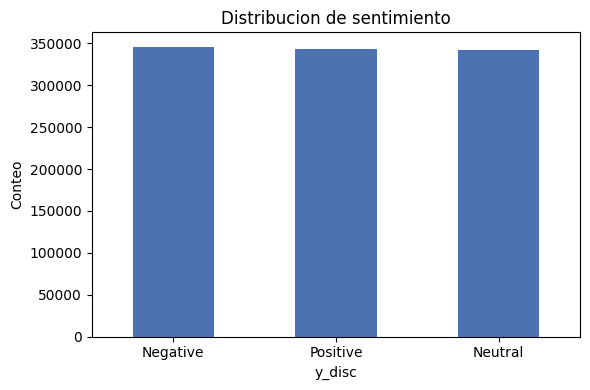

In [10]:
plt.figure(figsize=(6, 4))
df_model["y_disc"].value_counts().plot(kind="bar", color="#4C72B0")
plt.title("Distribucion de sentimiento")
plt.ylabel("Conteo")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



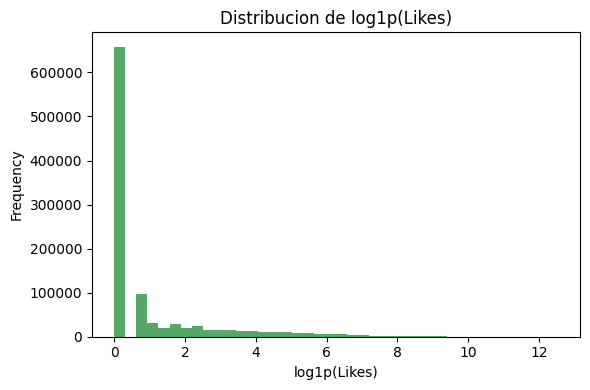

In [11]:
plt.figure(figsize=(6, 4))
np.log1p(df_model["Likes"]).plot(kind="hist", bins=40, color="#55A868")
plt.title("Distribucion de log1p(Likes)")
plt.xlabel("log1p(Likes)")
plt.tight_layout()
plt.show()



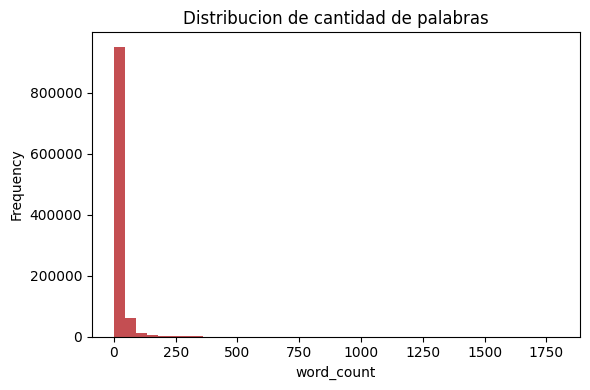

In [12]:
plt.figure(figsize=(6, 4))
df_model["word_count"].plot(kind="hist", bins=40, color="#C44E52")
plt.title("Distribucion de cantidad de palabras")
plt.xlabel("word_count")
plt.tight_layout()
plt.show()



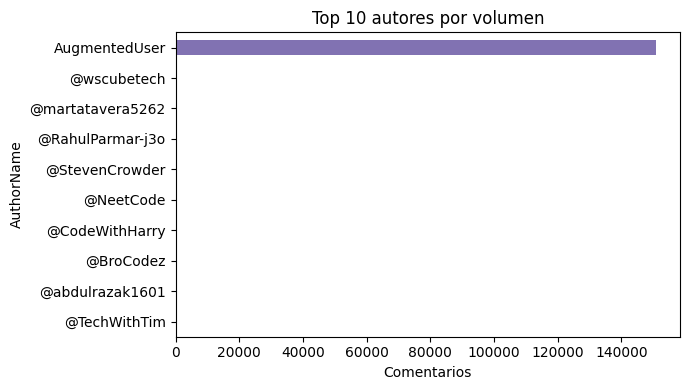

In [13]:
if "AuthorName" in df_model.columns:
    top_auth = df_model["AuthorName"].value_counts().head(10)
    plt.figure(figsize=(7, 4))
    top_auth.sort_values().plot(kind="barh", color="#8172B2")
    plt.title("Top 10 autores por volumen")
    plt.xlabel("Comentarios")
    plt.tight_layout()
    plt.show()



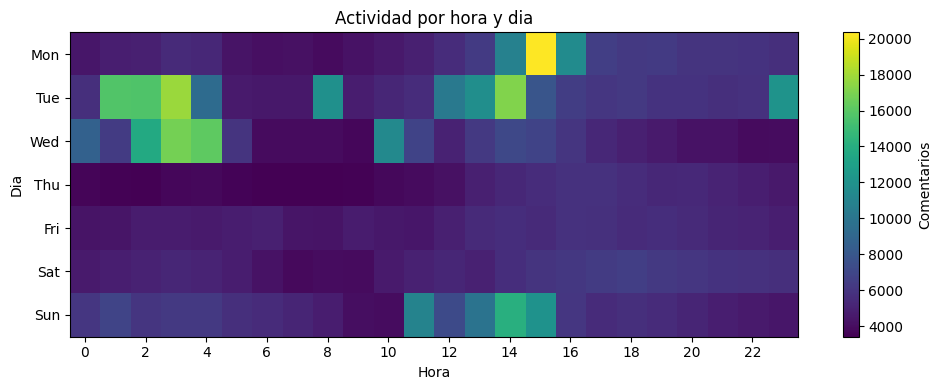

In [14]:
# Heatmap de actividad por hora y dia de la semana
if "hour" in df_model.columns and "dow" in df_model.columns:
    heat = (
        df_model.pivot_table(index="dow", columns="hour", values="CommentID", aggfunc="count")
        .fillna(0)
        .astype(int)
    )
    plt.figure(figsize=(10, 4))
    plt.imshow(heat, aspect="auto", cmap="viridis")
    plt.colorbar(label="Comentarios")
    plt.yticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    plt.xticks(ticks=range(0, 24, 2))
    plt.title("Actividad por hora y dia")
    plt.xlabel("Hora")
    plt.ylabel("Dia")
    plt.tight_layout()
    plt.show()



## 3) Variables objetivo (justificacion)

- Variable discreta: Sentiment (clasificacion)
- Variable continua: log1p(Likes) (regresion)

Se mantiene la justificacion de negocio: monitoreo de reputacion y prediccion de engagement.



In [15]:
df_model[["y_disc", "Likes", "y_cont"]].head(5)



,y_disc,Likes,y_cont
0,Neutral,0,0.000000
1,Positive,0,0.000000
2,Neutral,1,0.693147
3,Neutral,0,0.000000
4,Positive,3,1.386294


## 4) Modelos para variable discreta (clasificacion)

Se incluyen baselines, modelos comparables y metricas en train y test.



In [16]:
n_sample = min(200_000, len(df_model))
df_work = df_model.sample(n_sample, random_state=777)

X = df_work["CommentText"].astype(str)
y = df_work["y_disc"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=777, stratify=y
)

X_train.shape, X_test.shape



((140000,), (60000,))

In [17]:
def eval_clf(pipe, X_train, y_train, X_test, y_test):
    pipe.fit(X_train, y_train)
    pred_train = pipe.predict(X_train)
    pred_test = pipe.predict(X_test)

    out = {
        "train_acc": accuracy_score(y_train, pred_train),
        "test_acc": accuracy_score(y_test, pred_test),
        "train_f1": f1_score(y_train, pred_train, average="macro"),
        "test_f1": f1_score(y_test, pred_test, average="macro"),
    }

    try:
        if hasattr(pipe, "predict_proba"):
            scores = pipe.predict_proba(X_test)
        else:
            scores = pipe.decision_function(X_test)
        out["test_roc_auc_ovr"] = roc_auc_score(y_test, scores, multi_class="ovr")
    except Exception:
        out["test_roc_auc_ovr"] = np.nan

    return out

results_cls = []

# Baseline
baseline = DummyClassifier(strategy="most_frequent")
metrics = eval_clf(baseline, X_train, y_train, X_test, y_test)
metrics["model"] = "Dummy-most_frequent"
results_cls.append(metrics)

# Logistic Regression
try:
    log_reg = LogisticRegression(max_iter=1000, n_jobs=-1, multi_class="multinomial")
except TypeError:
    log_reg = LogisticRegression(max_iter=1000)

pipe_log = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.9)),
    ("model", log_reg)
])
metrics = eval_clf(pipe_log, X_train, y_train, X_test, y_test)
metrics["model"] = "LogReg"
results_cls.append(metrics)

results_cls



[{'train_acc': 0.33507857142857145,
  'test_acc': 0.3350666666666667,
  'train_f1': 0.16732027542520236,
  'test_f1': 0.16731582276374046,
  'test_roc_auc_ovr': 0.5,
  'model': 'Dummy-most_frequent'},
 {'train_acc': 0.8146714285714286,
  'test_acc': 0.6812666666666667,
  'train_f1': 0.8149144078452059,
  'test_f1': 0.6821319181028332,
  'test_roc_auc_ovr': 0.8512375762214877,
  'model': 'LogReg'}]

In [18]:
# SGD con busqueda aleatoria
pipe_sgd = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.9)),
    ("model", SGDClassifier(random_state=777))
])

param_dist = {
    "model__loss": ["log_loss", "modified_huber", "hinge"],
    "model__penalty": ["l2", "l1", "elasticnet"],
    "model__alpha": np.logspace(-6, -3, 20),
    "model__l1_ratio": np.linspace(0, 1, 6),
}

search_sgd = RandomizedSearchCV(
    pipe_sgd,
    param_distributions=param_dist,
    n_iter=20,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    random_state=777,
    verbose=1,
)

search_sgd.fit(X_train, y_train)

best_cls = search_sgd.best_estimator_

metrics = eval_clf(best_cls, X_train, y_train, X_test, y_test)
metrics["model"] = "SGD-best"
results_cls.append(metrics)

pd.DataFrame(results_cls).sort_values("test_f1", ascending=False)



Fitting 3 folds for each of 20 candidates, totalling 60 fits


,train_acc,test_acc,train_f1,test_f1,test_roc_auc_ovr,model
2,0.790150,0.682417,0.790408,0.683034,NaN,SGD-best
1,0.814671,0.681267,0.814914,0.682132,0.851238,LogReg
0,0.335079,0.335067,0.167320,0.167316,0.500000,Dummy-most_frequent


Best params: {'model__penalty': 'l2', 'model__loss': 'hinge', 'model__l1_ratio': np.float64(1.0), 'model__alpha': np.float64(1.8329807108324375e-05)}
              precision    recall  f1-score   support

    Negative       0.66      0.72      0.69     20104
     Neutral       0.63      0.64      0.63     19911
    Positive       0.77      0.69      0.73     19985

    accuracy                           0.68     60000
   macro avg       0.69      0.68      0.68     60000
weighted avg       0.69      0.68      0.68     60000



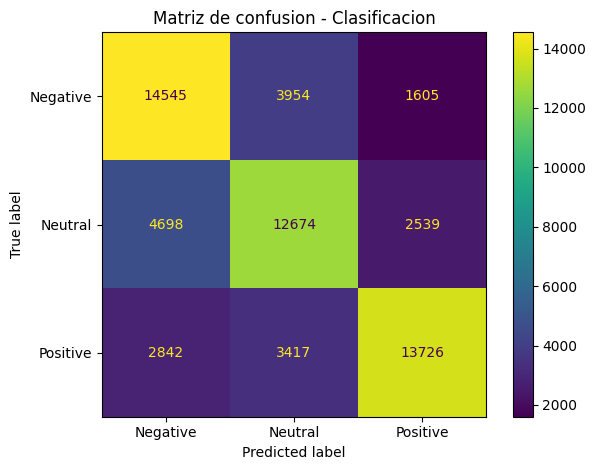

In [19]:
# Reporte final del mejor clasificador
pred = best_cls.predict(X_test)
print("Best params:", search_sgd.best_params_)
print(classification_report(y_test, pred))

ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.title("Matriz de confusion - Clasificacion")
plt.tight_layout()
plt.show()



## 5) Modelos para variable continua (regresion)

Se incluyen baselines, modelos comparables y metricas en train y test.



In [20]:
Xr = df_work["CommentText"].astype(str)
yr = df_work["y_cont"].astype(float)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    Xr, yr, test_size=0.30, random_state=777
)



In [21]:
def eval_reg(pipe, X_train, y_train, X_test, y_test):
    pipe.fit(X_train, y_train)
    pred_train = pipe.predict(X_train)
    pred_test = pipe.predict(X_test)

    out = {
        "train_mae": mean_absolute_error(y_train, pred_train),
        "test_mae": mean_absolute_error(y_test, pred_test),
        "train_rmse": np.sqrt(mean_squared_error(y_train, pred_train)),
        "test_rmse": np.sqrt(mean_squared_error(y_test, pred_test)),
        "train_r2": r2_score(y_train, pred_train),
        "test_r2": r2_score(y_test, pred_test),
    }

    return out

results_reg = []

# Baseline
baseline_r = DummyRegressor(strategy="mean")
metrics = eval_reg(baseline_r, X_train_r, y_train_r, X_test_r, y_test_r)
metrics["model"] = "Dummy-mean"
results_reg.append(metrics)

models_reg = {
    "LinReg": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=1e-4, max_iter=5000),
    "ElasticNet": ElasticNet(alpha=1e-4, l1_ratio=0.15, max_iter=5000),
    "SGDRegressor": SGDRegressor(penalty="l2", alpha=1e-5, random_state=777, max_iter=1000),
}

for name, model in models_reg.items():
    pipe = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.9)), ("model", model)])
    metrics = eval_reg(pipe, X_train_r, y_train_r, X_test_r, y_test_r)
    metrics["model"] = name
    results_reg.append(metrics)

pd.DataFrame(results_reg).sort_values("test_mae")



,train_mae,test_mae,train_rmse,test_rmse,train_r2,test_r2,model
4,1.139015,1.167452,1.616546,1.658475,0.142883,1.050685e-01,ElasticNet
2,0.854116,1.173876,1.226738,1.691608,0.506409,6.895352e-02,Ridge
3,1.174264,1.185233,1.662143,1.677203,0.093849,8.474257e-02,Lasso
5,1.170496,1.188512,1.652800,1.676747,0.104007,8.524107e-02,SGDRegressor
0,1.265767,1.269128,1.746096,1.753130,0.000000,-7.750822e-09,Dummy-mean
1,0.081544,11.979354,0.294294,17.461872,0.971593,-9.820952e+01,LinReg


In [22]:
# Grid search para Ridge
pipe_ridge = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.9)),
    ("model", Ridge())
])

grid = {"model__alpha": np.logspace(-2, 3, 15)}
search_ridge = GridSearchCV(pipe_ridge, grid, scoring="r2", cv=3, n_jobs=-1, verbose=1)
search_ridge.fit(X_train_r, y_train_r)

best_reg = search_ridge.best_estimator_
metrics = eval_reg(best_reg, X_train_r, y_train_r, X_test_r, y_test_r)
metrics["model"] = "Ridge-best"

pd.DataFrame(results_reg + [metrics]).sort_values("test_mae")



Fitting 3 folds for each of 15 candidates, totalling 45 fits


,train_mae,test_mae,train_rmse,test_rmse,train_r2,test_r2,model
6,1.055222,1.149782,1.510053,1.646674,0.252092,1.177590e-01,Ridge-best
4,1.139015,1.167452,1.616546,1.658475,0.142883,1.050685e-01,ElasticNet
2,0.854116,1.173876,1.226738,1.691608,0.506409,6.895352e-02,Ridge
3,1.174264,1.185233,1.662143,1.677203,0.093849,8.474257e-02,Lasso
5,1.170496,1.188512,1.652800,1.676747,0.104007,8.524107e-02,SGDRegressor
0,1.265767,1.269128,1.746096,1.753130,0.000000,-7.750822e-09,Dummy-mean
1,0.081544,11.979354,0.294294,17.461872,0.971593,-9.820952e+01,LinReg


## 6) Interpretacion del modelo

Se listan terminos que empujan hacia cada clase y terminos que aumentan/disminuyen engagement.



In [23]:
# Clasificacion: terminos por clase
if "tfidf" in best_cls.named_steps:
    tfidf = best_cls.named_steps["tfidf"]
    clf = best_cls.named_steps["model"]

    feat = np.array(tfidf.get_feature_names_out())
    classes = clf.classes_
    coefs = clf.coef_

    top_n = 15
    for i, c in enumerate(classes):
        top_pos = np.argsort(coefs[i])[-top_n:][::-1]
        print(f"\nClase {c} - terminos que empujan hacia {c}:")
        print(feat[top_pos])




Clase Negative - terminos que empujan hacia Negative:
['error' 'terrible' 'not' 'stupid' 'fake' 'worst' 'seriously' 'awful'
 'disgusting' 'dumb' 'garbage' 'hate' 'isn' 'sad' 'poor']

Clase Neutral - terminos que empujan hacia Neutral:
['is it' 'is that' 'is this' 'is there' 'can you' 'wondering' 'comment'
 'adaxum' 'thought' 'what is' 'could you' 'or' 'woke up' 'where' 'name']

Clase Positive - terminos que empujan hacia Positive:
['love' 'amazing' 'awesome' 'best' 'great' 'thank' 'loved' 'finally'
 'beautiful' 'good' 'brilliant' 'respect' 'perfect' 'glad' 'thank you']


In [25]:
# Regresion: terminos que aumentan/disminuyen engagement
if "tfidf" in best_reg.named_steps:
    tfidf_r = best_reg.named_steps["tfidf"]
    reg = best_reg.named_steps["model"]

    feat_r = np.array(tfidf_r.get_feature_names_out())
    coef_r = reg.coef_

    top_n = 20
    top_pos = np.argsort(coef_r)[-top_n:][::-1]
    top_neg = np.argsort(coef_r)[:top_n]

    print("Aumentan engagement (log1p likes):")
    print(feat_r[top_pos])

    print("Disminuyen engagement (log1p likes):")
    print(feat_r[top_neg])



Aumentan engagement (log1p likes):
['ben' 'debate' 'edit' 'canadian' 'kyle' 'love how' 'special'
 'congresswoman' 'ukraine' 'her' 'this man' 'proud' 'walz' 'conversation'
 '순간' 'level' 'imagine' 'felt' 'standing' 'crowder']
Disminuyen engagement (log1p likes):
['individuals' 'however' 'significant' 'which' 'likely' 'idiot'
 'can someone' 'encountered' 'for me' 'why' 'garbage' 'terrible'
 'incredibly' 'you people' 'considered' 'guys are' 'china' 'idiots'
 'vehicle' 'appears']


## 7) Conclusiones y siguientes pasos

- Reportar conclusiones con metricas de train y test.
- Interpretar en terminos de negocio: reputacion, priorizacion de respuesta, moderacion.
- Validar sesgos (idioma, longitud de texto, usuarios dominantes) y sensibilidad a balance de clases.
- Si se usa export de WhatsApp, documentar el parseo y evidenciar estructura {Fecha, Hora, Autor, Mensaje}.

